# This code is intended to be used for offline analysis of the magnetic data retreived from the WebDAQ during site surveying.

## You may need to update the widget package to make this work.

## pip install ipywidgets --upgrade
## conda install conda-forge::ipywidgets

## Do not run all
## Run one cell at a time or plots may not populate

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec
from scipy.fft import fftshift
import warnings

## This will be for the data you collect with the WebDAQ
### You'll have to remove the metadata from the csv file in order to run the script 

In [2]:
############################# If you are using Mac, you may need to remove the r before the path ###############################
seis = pd.read_csv(r"C:\Users\cacam\Documents\data_files\test_files\seismo_proper.csv", delimiter=',') 

sam = seis['Sample']
tim = seis['Time (s)']
noi = seis['Noise (V)']
z = seis['Channel Z (V)']
n = seis['Channel N (V)']
e = seis['Channel E (V)']

########################################### This is the sample rate we used in testing #########################################
fs = 1651.612903
############################################ If you used something else, put it here ###########################################

## This will be for the data you collect with the Minimus
### You'll have to remove the metadata as well
### Make sure the times are the same

In [84]:
seisz = pd.read_csv(r"C:\Users\cacam\Documents\data_files\huddle_files\2024-08-14_Z_2.csv", delimiter=',')
seisn = pd.read_csv(r"C:\Users\cacam\Documents\data_files\huddle_files\2024-08-14-E_2.csv", delimiter=',')
seise = pd.read_csv(r"C:\Users\cacam\Documents\data_files\huddle_files\2024-08-14-N_2.csv", delimiter=',')

tim = seisz['Time']
z = seisz['Sample'] #* 10 ** -3 
n = seisn['Sample'] #* 10 ** -3
e = seise['Sample'] #* 10 ** -3

################################################ Do not change this value ######################################################
fs = 200

## The following cell displays the time series of the recorded data

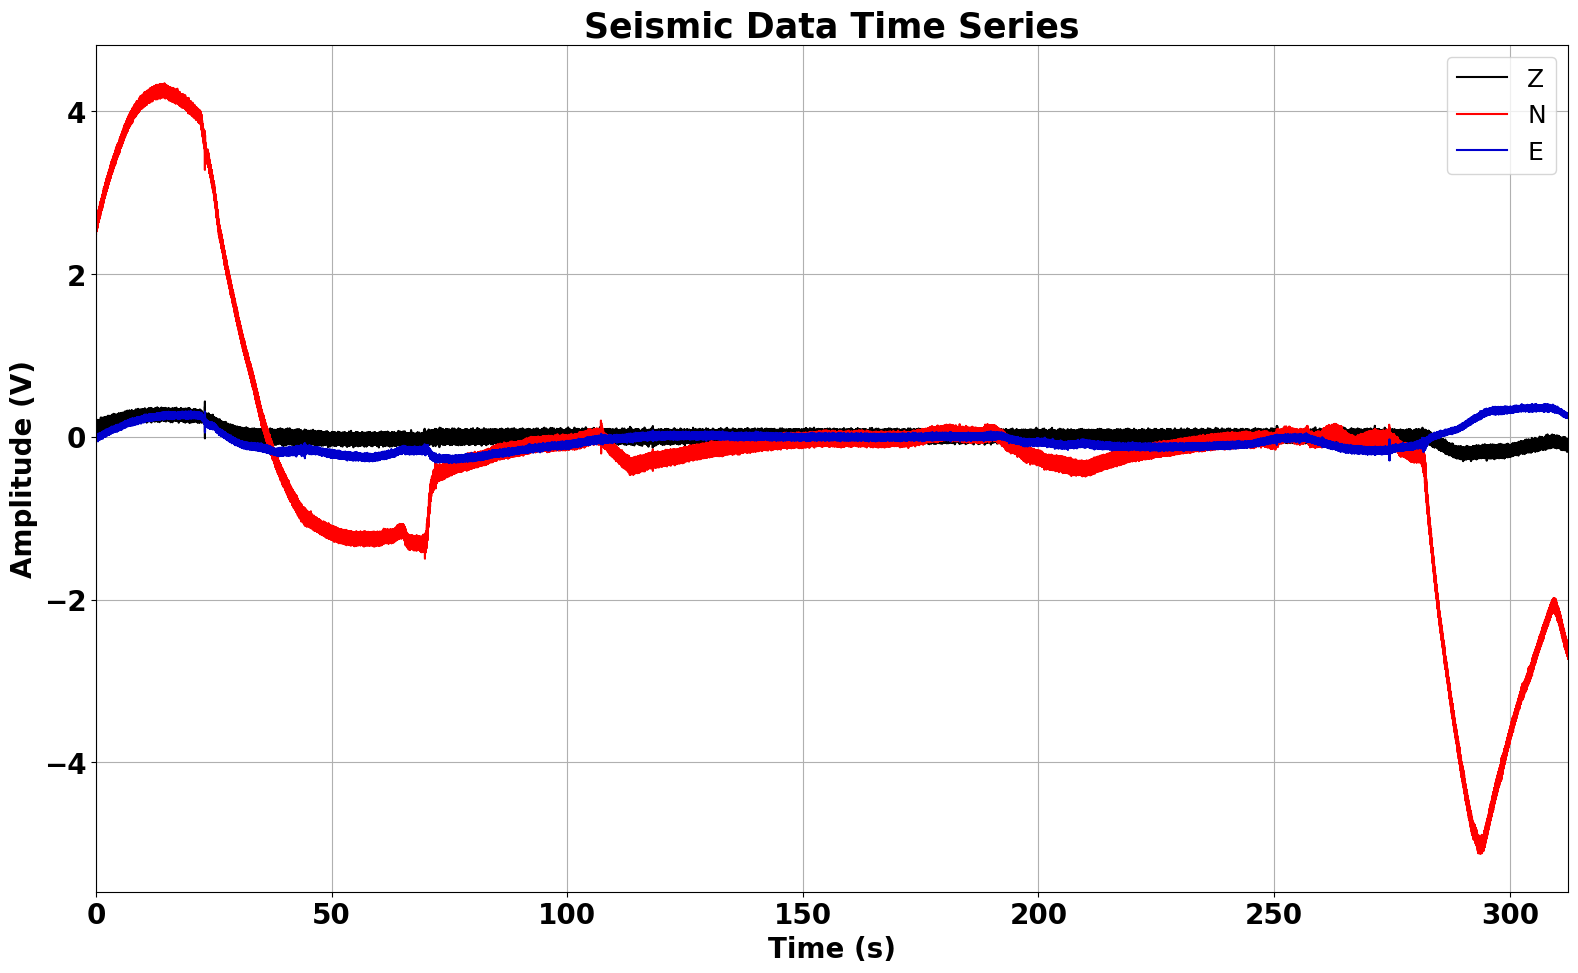

In [3]:
plt.figure(figsize = (19, 11))

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################

plt.plot(tim,z, linewidth = 1.5, color = 'black', label = 'Z') 
plt.plot(tim,n, linewidth = 1.5, color = 'red', label = 'N')
plt.plot(tim,e, linewidth = 1.5, color = 'mediumblue', label = 'E')
#plt.plot(tim,noi, linewidth = 1.5, color = 'yellow', label = 'Noise')

plt.legend(loc = "upper right", fontsize = 18)
plt.title("Seismic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
plt.xlim(0, tim[len(tim)-1])
#plt.ylim()
plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")
plt.grid(True)

#.savefig('**place_img_name_here.format**', bbox_inches='tight')

## If you want to look at a specific time along the time series, you can use the slider plot below. 

### These variables are used to adjust the how many seconds are displayed and the step length

In [4]:
win = 15  ## sec displayed
stepy = 4  ## sec moved

## Beware, there is a slight time delay when slidering

## If the slider is not workering move to the next cell

In [5]:
Min = min(z.min(), n.min(), e.min())  ########################## This is to find the window height #############################
Max = max(z.max(), n.max(), e.max())

##################################### This function is what makes the slider run ###############################################
######################################### Parameters can be changed as needed ##################################################

def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(tim, z, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(tim, n, linewidth = 1.5, label = 'N', color = 'red')
    plt.plot(tim, e, linewidth = 1.5, label = 'E', color = 'blue')
    
    plt.xlim(xlim, xlim + win) ####################### This is how long the window is (CAN be changed) #########################
    plt.ylim(Min - 1, Max + 1) ################## This adds a buffer to the window height (CAN be changed) #####################
    
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Slider Time Series", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
    plt.yticks(fontsize = 20, fontweight = "bold")
    plt.xticks(fontsize = 20, fontweight = "bold")
    plt.grid(True)
    plt.show()

######################################## This is where the slider plot gets plotted ############################################
#### min,max = start,end ; step is the increment it slides on ; value is where it starts ; layout is how long the slider is ####
############################################### step and layout CAN be changed #################################################

interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (tim[len(tim)-1]), step = stepy, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=312.440645,…

<function __main__.plot_with_slider(xlim)>

## If the slider is not working, you can use this cell to manually change the limits to look at a specific area of the time series.

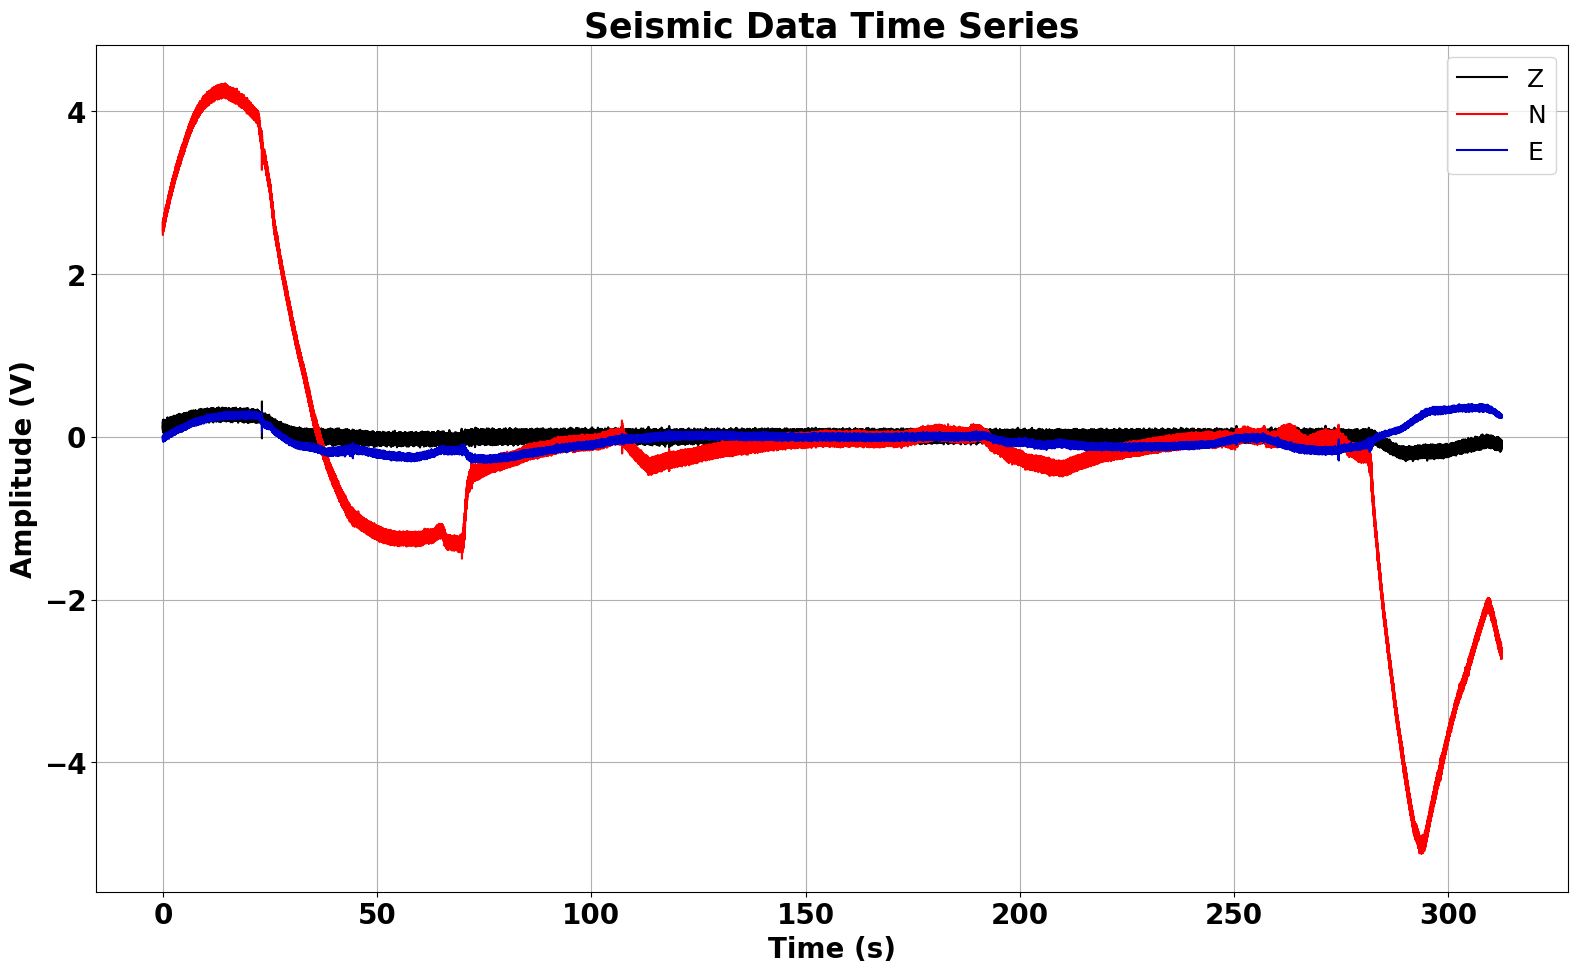

In [6]:
plt.figure(figsize = (19, 11))

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################

plt.plot(tim,z, linewidth = 1.5, color = 'black', label = 'Z') 
plt.plot(tim,n, linewidth = 1.5, color = 'red', label = 'N')
plt.plot(tim,e, linewidth = 1.5, color = 'mediumblue', label = 'E')
#plt.plot(tim,noi, linewidth = 1.5, color = 'yellow', label = 'Noise')

plt.legend(loc = "upper right", fontsize = 18)
plt.title("Seismic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
#plt.xlim()
#plt.ylim()
plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")
plt.grid(True)

#.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cells are used to plot spectrograms for each direction

### These variables are to set the color magnitude limits of the spectrogram and the y limits

In [7]:
cmin = 0.0001
cmax = 0.005

ymax = 20 ## In terms of frequency
ymin = 0

'\naxis4 = fig.add_subplot(gs[3,0])\n\naxis4.set_title("Noise Direction", fontweight = \'bold\' , fontsize = 20)\n\nm3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading=\'gouraud\', vmin = cmin, vmax = cmax)\n\naxis3.set_title("Electronic Noise", fontweight = \'bold\' , fontsize = 20)\naxis3.set_xlabel(\'Time (s)\', fontweight = \'bold\' , fontsize = 18)\naxis4.set_ylabel(\'Frequency (Hz)\', fontweight = \'bold\' , fontsize = 18)\naxis3.tick_params(labelsize=16)\n\ncbar3 = fig.colorbar(m3, pad = 0.02)\ncbar3.ax.tick_params(labelsize=14)\ncbar3.set_label(label=\'Intensity [m/s/Hz^0.5]\' ,weight=\'bold\', fontsize = 14)\n\n\naxis4.set_.ylim(ymin, ymax)\n\nplt.savefig(\'**place_img_name_here.format**\', bbox_inches=\'tight\')\n'

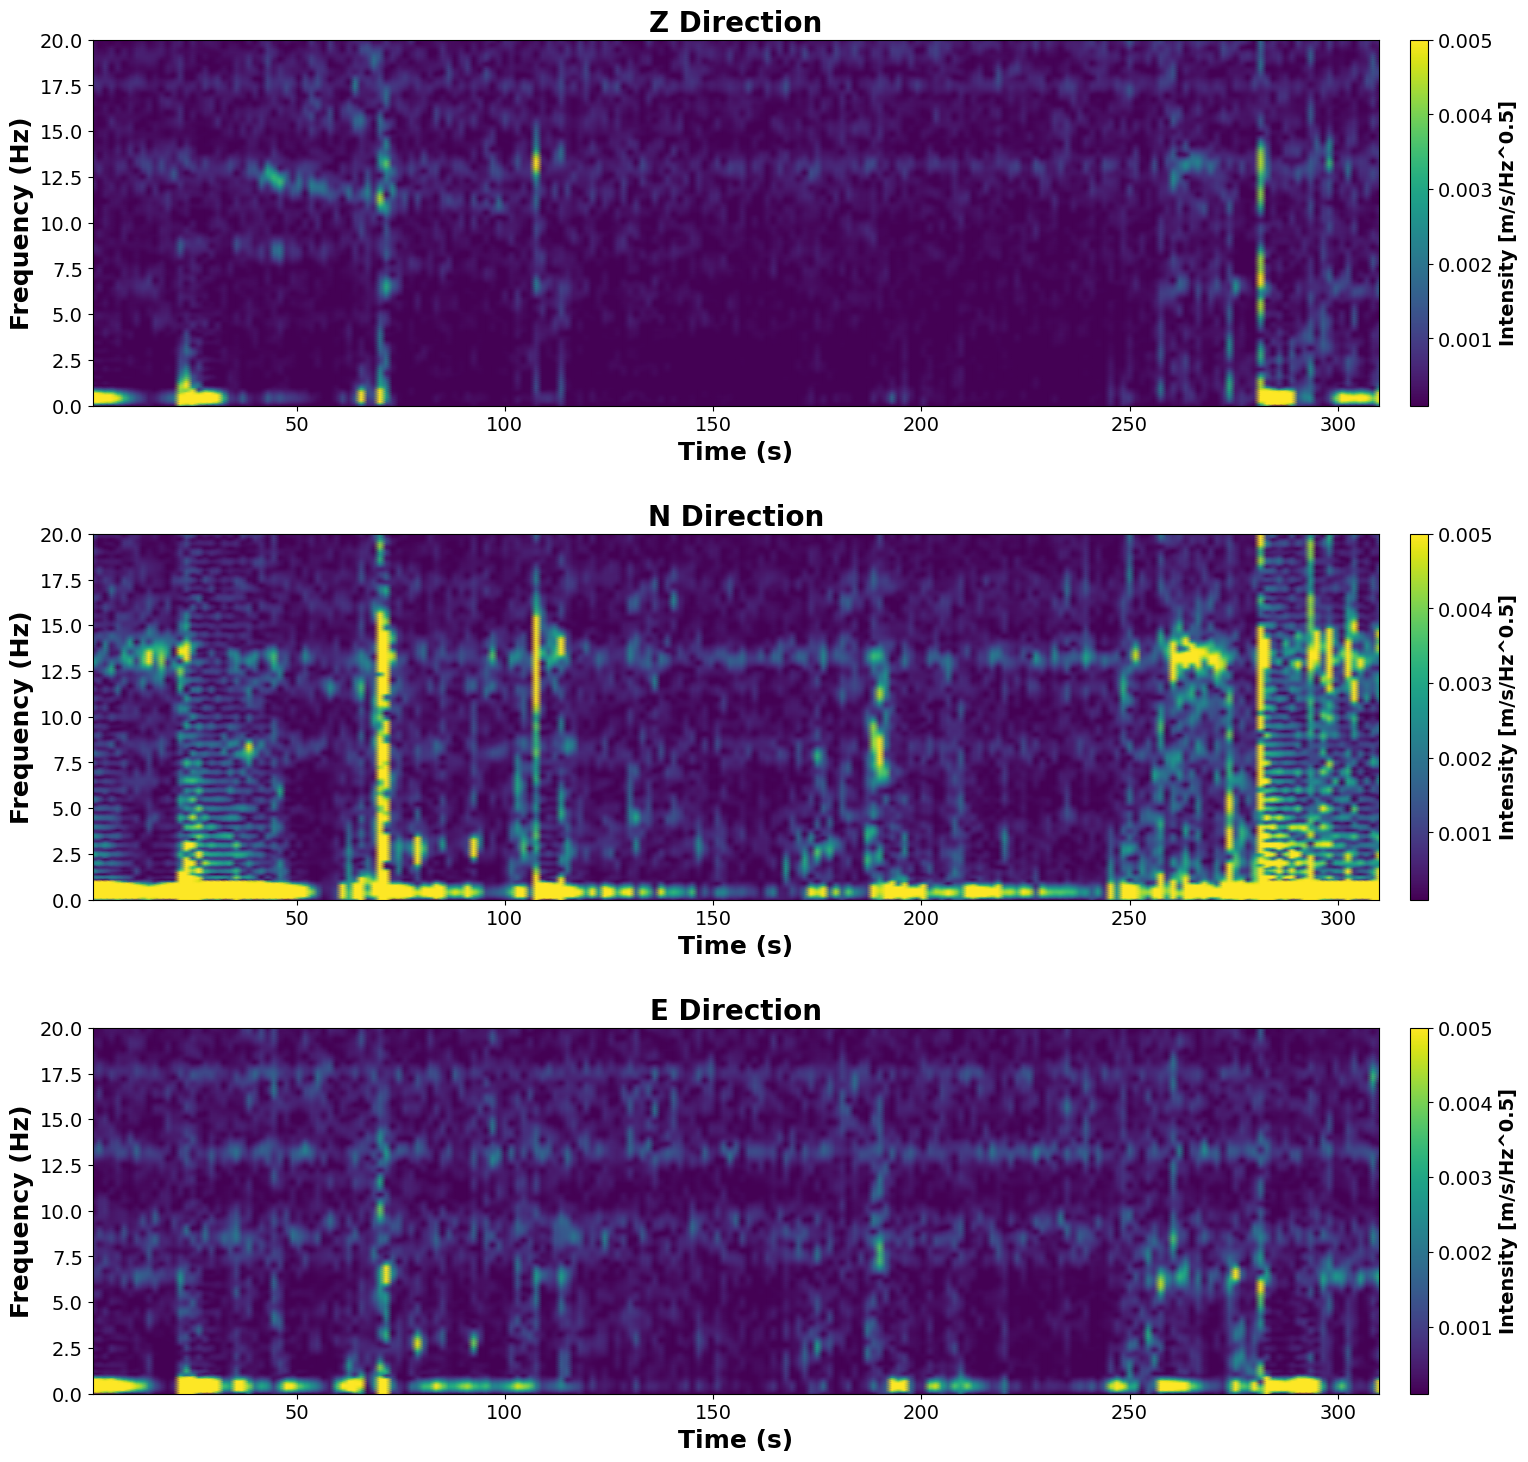

In [17]:
################################################################################################################################
###################### The spectrograms are calculated with signal.spectrogram from SciPy ######################################
################################################################################################################################
warnings.simplefilter('ignore')

fz, tz, Sxxz = signal.spectrogram(z, fs, window= 'hamming', nperseg=round(fs *2), nfft= round(fs *10), noverlap= round(fs / 2))
fn, tn, Sxxn = signal.spectrogram(n, fs, window= 'hamming', nperseg=round(fs *2), nfft= round(fs *10), noverlap= round(fs / 2))
fe, te, Sxxe = signal.spectrogram(e, fs, window= 'hamming', nperseg=round(fs *2), nfft= round(fs *10), noverlap= round(fs / 2))
f, t, Sxx = signal.spectrogram(noi, fs, window= 'hamming', nperseg=round(fs *2), nfft= round(fs *10), noverlap= round(fs / 2))


fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(4,1, height_ratios = [1,1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud', vmin = cmin, vmax = cmax)

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)
axis1.set_xlabel('Time (s)', fontweight = 'bold' , fontsize = 18)
axis1.set_ylabel('Frequency (Hz)', fontweight = 'bold' , fontsize = 18)
axis1.tick_params(labelsize=14)

cbar0 = fig.colorbar(m0, label='Intensity [m/s/Hz^0.5]', pad =0.02)
cbar0.ax.tick_params(labelsize=14)
cbar0.set_label(label='Intensity [m/s/Hz^0.5]' ,weight='bold', fontsize = 14)

axis1.set_ylim(ymin,ymax)


####################################################### Channel N ##############################################################

axis2 = fig.add_subplot(gs[1,0])

m1 = axis2.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud', vmin = cmin, vmax = cmax)

axis2.set_title("N Direction", fontweight = 'bold' , fontsize = 20)
axis2.set_xlabel('Time (s)', fontweight = 'bold' , fontsize = 18)
axis2.set_ylabel('Frequency (Hz)', fontweight = 'bold' , fontsize = 18)
axis2.tick_params(labelsize=14)

cbar1 = fig.colorbar(m1, pad =0.02)
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label(label='Intensity [m/s/Hz^0.5]' ,weight='bold', fontsize = 14)

axis2.set_ylim(ymin, ymax)

####################################################### Channel E ##############################################################

axis3 = fig.add_subplot(gs[2,0])

m2 = axis3.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title("E Direction", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time (s)', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency (Hz)', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=14)

cbar2 = fig.colorbar(m2, pad =0.02)
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label(label='Intensity [m/s/Hz^0.5]' ,weight='bold', fontsize = 14)

axis3.set_ylim(ymin, ymax)


###################################################### Noise Channel ###########################################################
'''
axis4 = fig.add_subplot(gs[3,0])

axis4.set_title("Noise Direction", fontweight = 'bold' , fontsize = 20)

m3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title("Electronic Noise", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time (s)', fontweight = 'bold' , fontsize = 18)
axis4.set_ylabel('Frequency (Hz)', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=16)

cbar3 = fig.colorbar(m3, pad = 0.02)
cbar3.ax.tick_params(labelsize=14)
cbar3.set_label(label='Intensity [m/s/Hz^0.5]' ,weight='bold', fontsize = 14)


axis4.set_ylim(ymin, ymax)

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')
'''
################################################################################################################################
################################## These will take a while to plot, since they are so dense ####################################

## If you want to look at spectra of specific parts of the time series, you can set the time limits here

## If not, skip the following two cells

In [ ]:
################################### Enter how long of a time segment you'd like to look at #####################################
start = 0  ## In terms of seconds
end = 100

## These are loops to index the dataframes

In [ ]:
d = 0 ################################################# Variables for loops ####################################################
f = 0

################# If you want to look at the whole time series you can change the variables in the next cell ###################
################################################################################################################################

for d in range(0, len(tim)): ################ These are to find the index values of start,end from the data file ###############
    if round(tim[d]) == start:
        gamma = sam[d]
        break
        
for f in range(0, len(tim)):
    if round(tim[f]) == end:
        delta = sam[f]
        break

################################################### The data gets sliced #######################################################

t1 = tim[gamma:delta]
#no = noi[gamma:delta]
z1 = z[gamma:delta]
n1 = n[gamma:delta]
e1 = e[gamma:delta]

## This cell is where the ASD is calculated and plotted

In [9]:
##################################################### Plot limits ##############################################################

y_max = 10e-1
y_min = 50e-4 

x_max = 100
x_min = 0.1

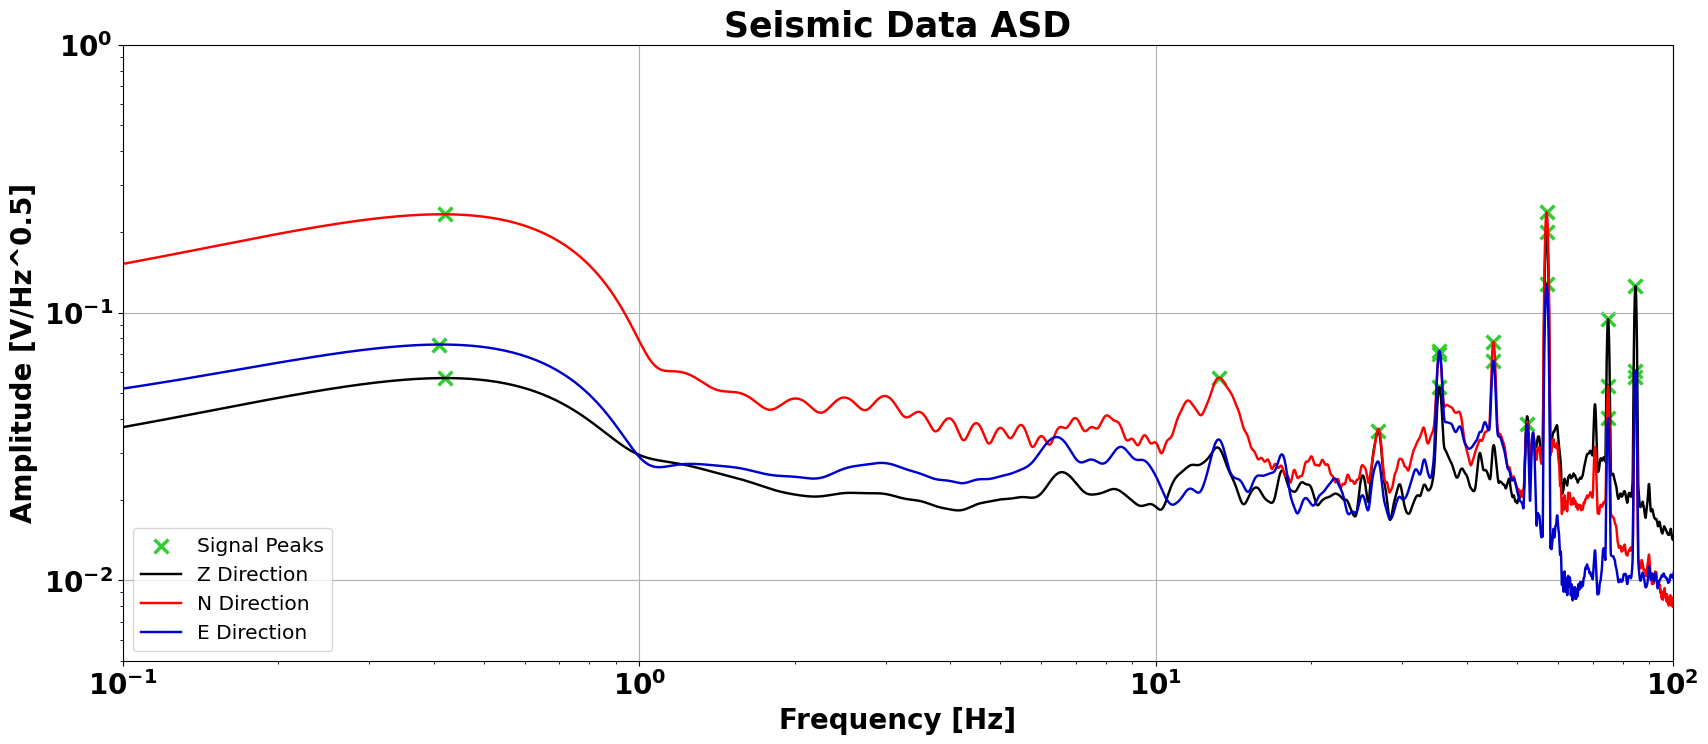

In [11]:
################################################################################################################################
######################################## The PSD is calculated via welch from scipy ############################################
################################################################################################################################
warnings.simplefilter('ignore')

############ If you don't want to look at the whole time series, you can add '1' to the variables, i.e k1, j1, i1 ##############

f_z, Pxx_den_z = signal.welch(z, fs, window= 'hamming', nperseg= (fs *2), nfft= (fs *100), noverlap= round(fs / 2) )
f_n, Pxx_den_n = signal.welch(n, fs, window= 'hamming', nperseg= (fs *2), nfft= (fs *100), noverlap= round(fs / 2) )
f_e, Pxx_den_e = signal.welch(e, fs, window= 'hamming', nperseg= (fs *2), nfft= (fs *100), noverlap= round(fs / 2) )

################### nfft is how long the fft bin lengths, noverlap is bin overlap, window is the window used ###################
####################### We used 100 sec bins, 0.5 sec overlap, and hamming window, these can be changed ########################
################################################ # DO NOT CHANGE/REMOVE 'fs' # #################################################

az = np.sqrt(Pxx_den_z)
an = np.sqrt(Pxx_den_n) ################################ This turns the PSD into an ASD ########################################
ae = np.sqrt(Pxx_den_e)


log_z = np.log(az)
log_n = np.log(an) ############ The log of each PSD must be found in order to find the peaks/frequences #################
log_e = np.log(ae)


peak_z, _ = signal.find_peaks(log_z, prominence = 1.2) ############## This is where the frequencies are found ##################
peak_n, _ = signal.find_peaks(log_n, prominence = 1.2) ############### If some are missed or there are extra ###################
peak_e, _ = signal.find_peaks(log_e, prominence = 1.2) ########## you will need to change the prominence variable ##############


################################################################################################################################
##################################################### Plots peaks ##############################################################

plt.figure(figsize = (20, 8))#, dpi = 2500)

plt.scatter(f_z[peak_z], az[peak_z] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], an[peak_n] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], ae[peak_e] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

###################################################### PLots data ##############################################################

plt.yscale('log')
plt.xscale('log')

plt.plot(f_z, az ** 0.5, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, an ** 0.5, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, ae ** 0.5, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5)

plt.title("Seismic Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [V/Hz^0.5]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

plt.grid(True)

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cell will plot each of direction signal in their own respective plots
### If you don't want/need to look at them individually, you don't have to run it

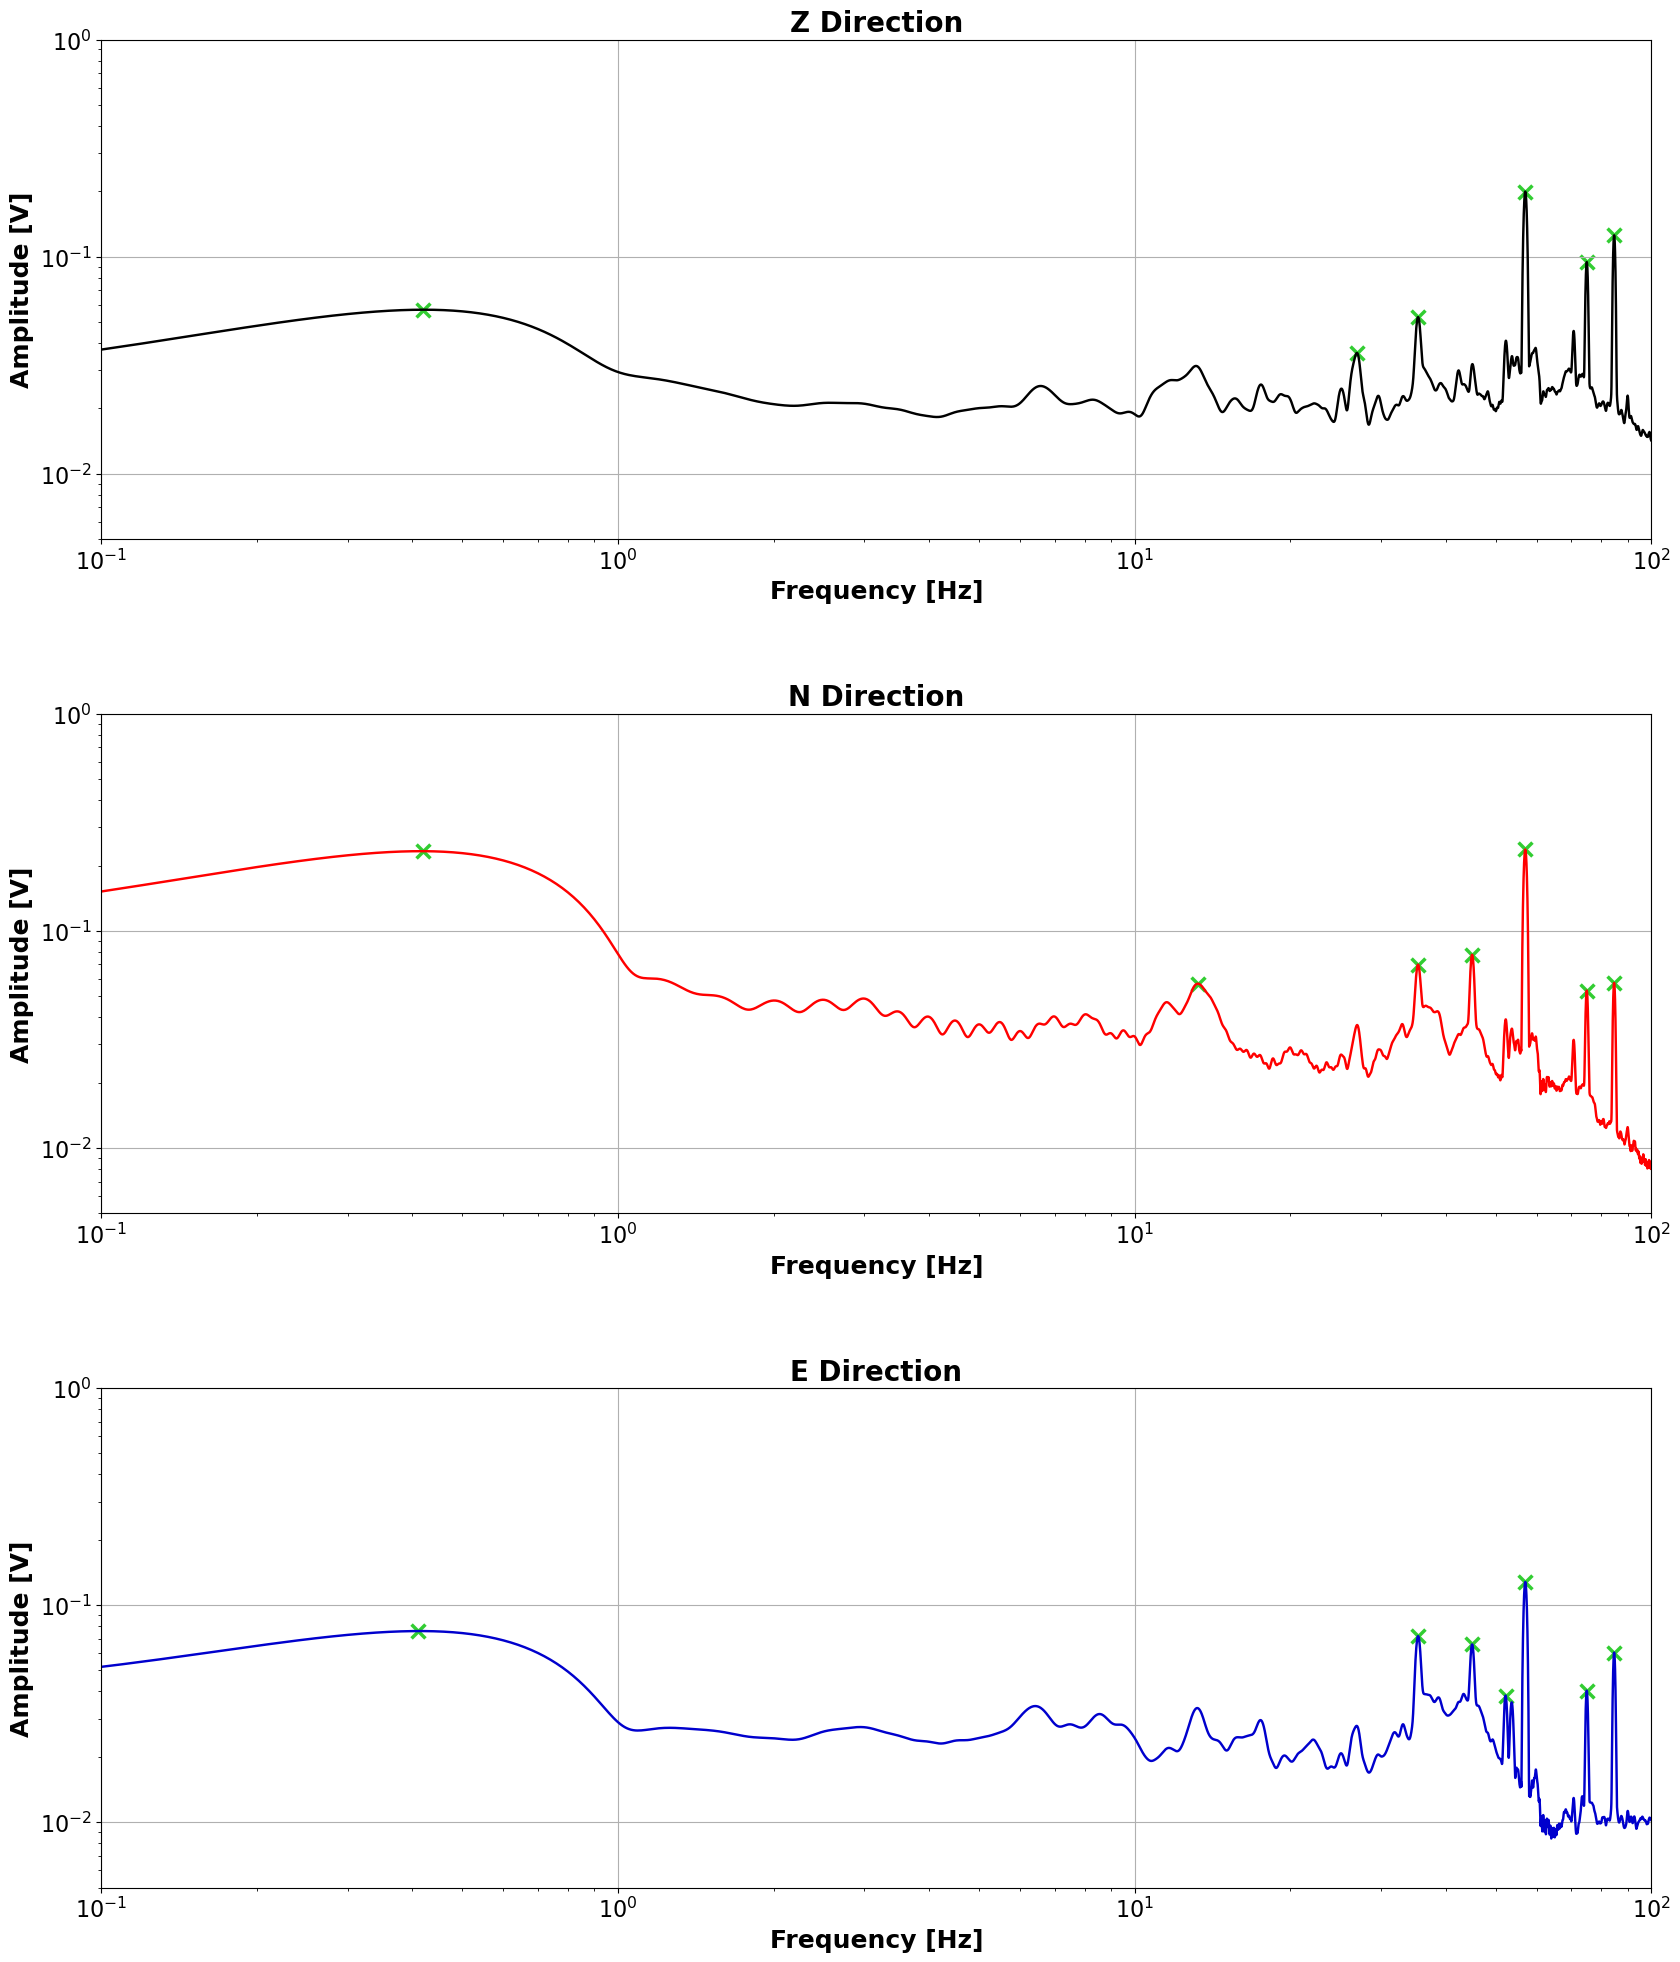

In [19]:
################################################################################################################################
############################# This gets plotted as a multipanel plot via gridspec and subplot ##################################
################################################################################################################################

fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)

axis1.set_yscale('log')
axis1.set_xscale('log')

axis1.scatter(f_z[peak_z], az[peak_z] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
axis1.plot(f_z, az ** 0.5, color = 'black', linewidth = 1.75, label = 'Z Direction')

axis1.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude [V]", fontweight = "bold", fontsize = 18)
axis1.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis1.grid(True)

####################################################### Channel N ##############################################################

axis2 = fig.add_subplot(gs[1,0])

axis2.set_title("N Direction", fontweight = "bold", fontsize = 20)

axis2.set_yscale('log')
axis2.set_xscale('log')

axis2.scatter(f_n[peak_n], an[peak_n] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
axis2.plot(f_n, an ** 0.5, color = 'red', linewidth = 1.75, label = 'N Direction')

axis2.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude [V]", fontweight = "bold", fontsize = 18)
axis2.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis2.grid(True)

####################################################### Channel E ##############################################################

axis3 = fig.add_subplot(gs[2,0])

axis3.set_title("E Direction", fontweight = "bold", fontsize = 20)

axis3.set_yscale('log')
axis3.set_xscale('log')

axis3.scatter(f_e[peak_e], ae[peak_e] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
axis3.plot(f_e, ae ** 0.5, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

axis3.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude [V]", fontweight = "bold", fontsize = 18)
axis3.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis3.grid(True)

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## This cell will output all the frequencies found and their respective amplitudes into a csv file

In [ ]:
####################################################### # # # # # # ############################################################
################################################### # SPAGHETTI CODE # #########################################################
###################################################### # # # # # # # ###########################################################
################################################################################################################################
###################################### Since each direction has a different number of peaks ####################################
############################################### They cannot be printed out right ###############################################
########################################### So they have to be made the same length ############################################
################################################################################################################################

l = 0 ################################################## Variables for loops ###################################################
m = 0
o = 0
q = 0

index = [] ############################################ Empty sets to be appended to ###########################################
roll = []
inventory = []

tsukishima = max(len(f_e[peak_e]), len(f_n[peak_n]), len(f_z[peak_z])) # Finds the directions with the most peaks, i.e longest #

for q in range(0, tsukishima - len(f_e[peak_e])): ############# The shorter data sets will be made equal with 'Nan' ############
    inventory.append('NaN')                       ################## Nothing will happen to the longest set ####################
for m in range(0, tsukishima - len(f_n[peak_n])): ################ If they are the same length nothing happens #################
    index.append('NaN')
for o in range(0, tsukishima - len(f_z[peak_z])):
    roll.append('NaN')

################################################################################################################################
######################################### This path is where the file gets outputted ###########################################
####################################################### Change as need #########################################################

with open (r"data\file\destination",'w') as f: 
        f.write('Frequency_E (HZ), Amplitude_E (V), Frequency_N (Hz), Amplitude_N (V), Frequency_Z (Hz), Amplitude_Z (V)\n')
        
        for l in range(0, tsukishima):
            if (len(f_e[peak_e]) != len(f_n[peak_n]) != len(f_z[peak_z])):                
                if len(f_e[peak_e]) == tsukishima:      
                    
############################################# The files are made the same length ###############################################

                    dir3 = np.append(f_n[peak_n], index)
                    dir_3 = np.append(Pxx_den_n[peak_n], index)
                    dir4 = np.append(f_z[peak_z], roll)
                    dir_4 = np.append(Pxx_den_z[peak_z], roll)

##################################### This where the dat points get printed in the file ########################################

                    f.write(str(f_e[peak_e][l]) + ',' + str(Pxx_den_e[peak_e][l]) + ',' +    
                            str(dir3[l]) + ',' + str(dir_3[l]) + ',' +
                            str(dir4[l]) + ',' + str(dir_4[l]) + '\n')
                    
###################### The elif's are for if a different direction has more peaks, longest data set ############################

                elif len(f_n[peak_n]) == tsukishima:
                    
                    dir3 = np.append(f_e[peak_e], inventory)
                    dir_3 = np.append(Pxx_den_e[peak_e], inventory)
                    dir4 = np.append(f_z[peak_z], roll)
                    dir_4 = np.append(Pxx_den_z[peak_z], roll)
                    
                    f.write(str(dir3[l]) + ',' + str(dir_3[l]) + ',' +    
                            str(f_n[peak_n][l]) + ',' + str(Pxx_den_n[peak_n][l]) + ',' +
                            str(dir4[l]) + ',' + str(dir_4[l]) + '\n')

                    
                elif len(f_z[peak_z]) == tsukishima:
                    
                    dir3 = np.append(f_e[peak_e], inventory)
                    dir_3 = np.append(Pxx_den_e[peak_e], inventory)
                    dir4 = np.append(f_n[peak_n], index)
                    dir_4 = np.append(Pxx_den_n[peak_n], index)
                    
                    f.write(str(dir3[l]) + ',' + str(dir_3[l]) + ',' +    
                            str(dir4[l]) + ',' + str(dir_4[l]) + ',' +
                            str(f_z[peak_z][l]) + ',' + str(f_z[peak_z][l]) + '\n')

############################### If the data sets are the same length the data will be printed here #############################

            else:
                f.write(str(f_e[peak_e][l]) + ',' + str(Pxx_den_e[peak_e][l]) + ',' +    
                        str(f_n[peak_n][l]) + ',' + str(Pxx_den_n[peak_n][l]) + ',' +
                        str(f_z[peak_z][l]) + ',' + str(Pxx_den_z[peak_z][l]) + '\n')
print('It ran')